In [16]:
import torch
import numpy as np
import torch.nn as nn

class SensoryNeurons(nn.Module):
    
    def __init__(self, num_neurons, in_dim = 1, plastic = True, params = (5, -2.5)):
        super(SensoryNeurons, self).__init__()
        
        self.in_dim = in_dim
        self.plastic = plastic
        self.params = params
        self.num_neurons = num_neurons

        self.linear = nn.Linear(self.in_dim,self.num_neurons, bias = True)
        self.resp_func = nn.Sigmoid()

        if not self.plastic:
            self.set_linear_weights()
            self.linear.weight.requires_grad = False
        
    def set_linear_weights(self):
        
        self.linear.weight = torch.nn.Parameter(data = self.params[0] + 0.2*torch.randn(self.num_neurons,1), requires_grad = False)
        self.linear.bias = torch.nn.Parameter(data = self.params[1] + 0.2*torch.randn(self.num_neurons), requires_grad = False)

    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.resp_func(x)
        
        return x
        
        
        
class SensoryPopulation(nn.Module):
    def __init__(self, num_neurons, plastic = True, population_ratio = 0.5):
        super(SensoryPopulation, self).__init__()
        
        self.num_neurons = num_neurons
        self.plastic = plastic
        self.num_neurons_group1 = int(self.num_neurons * population_ratio)
        self.num_neurons_group2 = int(self.num_neurons * (1 - population_ratio))
        
        self.sensory_neurons_1 = SensoryNeurons(num_neurons = self.num_neurons_group1, in_dim = 1, plastic = self.plastic, params = (5, -2.5))
        self.sensory_neurons_2 = SensoryNeurons(num_neurons = self.num_neurons_group2, in_dim = 1, plastic = self.plastic, params = (-5, -2.5))
        
    def forward(self,x):
        
        x1 = self.sensory_neurons_1(x)
        x2 = self.sensory_neurons_2(x)
        
        out = torch.cat((x1, x2),dim = 1)       
        
        return out
            
        
    
class Readout(nn.Module):
    def __init__(self,num_classes = 2, in_dim = 10):
        super(Readout, self).__init__()
        
        self.num_classes = num_classes
        self.in_dim = in_dim
        
        self.readout_layer = nn.Linear(self.in_dim, self.num_classes)
        
        
    def forward(self, x):
        
        return self.readout_layer(x)
    
    
class Sensorimotor(nn.Module):
    def __init__(self, num_sensory_neurons = 10, sensory_plastic = True, sensory_pop_ratio = 0.5, num_classes = 2):
        super(Sensorimotor, self).__init__()
        
        self.sensory_pop = SensoryPopulation(num_neurons = num_sensory_neurons, plastic = sensory_plastic, population_ratio = sensory_pop_ratio)
        self.readout = Readout(num_classes = num_classes, in_dim = num_sensory_neurons)
        
    def forward(self, x):
        
        sensory_out = self.sensory_pop(x)
        y = self.readout(sensory_out)
        
        return y
        
        
    

In [17]:
from torch.utils import data

class Stimulus(data.DataLoader):
    def __init__(self, min_coherence = 0.8, max_coherence = 1):
        
        self.min_coherence = min_coherence
        self.max_coherence = max_coherence
        
        self.NUM_SAMPLPES_PER_CATEGORY = 1000
        
        data1 = torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence
        data2 = -torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence
        target1 = torch.zeros(data1.shape, dtype = int)
        target2 = torch.ones(data2.shape, dtype = int)
        
        self.data = torch.cat((data1, data2), dim = 0).unsqueeze(0).t()
        self.target = torch.cat((target1, target2), dim = 0).unsqueeze(0).t()
 
    def __getitem__(self, index):
        
        
        return (self.data[index], self.target[index])
    
    def __len__(self):
        
        return len(self.data)
    
     
        
        

In [61]:
from torch.utils import data
import torch.optim as optim

def main(num_epochs = 1000, lr = 1e-1, batch_size = 100):
    
    model = Sensorimotor(num_sensory_neurons = 10, sensory_plastic = False, sensory_pop_ratio = 0.5, num_classes = 2)
    
    print('\n===========Check Grad============')
    for name, param in model.named_parameters():
        print(name, param.requires_grad)
    print('=================================\n')    
    
    params = model.parameters()
    
    optimizer = optim.SGD(params, lr=lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
    loss = nn.CrossEntropyLoss()
    
    dataset_train = Stimulus(min_coherence = 0, max_coherence = 0.2)
    dataset_valid = Stimulus(min_coherence = 0, max_coherence = 0.2)
    
    sampler_train = data.RandomSampler(dataset_train)
    train_dl = data.DataLoader(dataset_train,
                             batch_size=batch_size,
                             sampler=sampler_train,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=True)
    
    sampler_valid = data.RandomSampler(dataset_valid)
    valid_dl = data.DataLoader(dataset_valid,
                             batch_size=batch_size,
                             sampler=sampler_valid,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=True)
    


    all_loss = []
    all_loss_valid = []
    for epoch in range(num_epochs):
        Loss = 0
        
        for stimulus, target in train_dl:
            
            decision = model(stimulus)
            
            L = loss(decision, target.squeeze())
            Loss += L/len(train_dl)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()

            del L
            
            
        Loss_valid = 0
        
        for stimulus, target in valid_dl:
            
            with torch.no_grad():
                decision = model(stimulus)

                L = loss(decision, target.squeeze())
                Loss_valid += L/len(train_dl)
                

                del L
        
        all_loss.append(Loss)
        all_loss_valid.append(Loss_valid)
        
        
        # print(f'epoch {epoch},   training Loss = {Loss},   validation Loss = {Loss_valid}')
    return all_loss, all_loss_valid
            
            
            
            
        
        
        
    
    


===========Check Grad============
sensory_pop.sensory_neurons_1.linear.weight True
sensory_pop.sensory_neurons_1.linear.bias True
sensory_pop.sensory_neurons_2.linear.weight True
sensory_pop.sensory_neurons_2.linear.bias True
readout.readout_layer.weight True
readout.readout_layer.bias True

Final train loss = 0.01921575888991356,    valid loss = 0.01979891024529934 



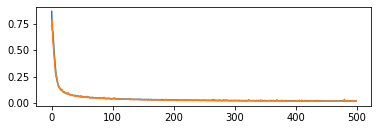

In [62]:
num_epochs = 500
lr = 1
batch_size = 100

loss, loss_valid = main(num_epochs = num_epochs, lr = lr, batch_size = batch_size)
print(f'Final train loss = {loss[-1]},    valid loss = {loss_valid[-1]} \n')
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(0,num_epochs),loss)
plt.plot(np.arange(0,num_epochs),loss_valid)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

Training and validation loss for different ranges of min and max coherences:
Sensory plasticity OFF:

0-0.2 --> Final train loss = 0.0577029325067997,    valid loss = 0.05982879921793938 

0.2-0.4 --> Final train loss = 0.046443745493888855,    valid loss = 0.04600318521261215

0.4-0.6 --> Final train loss = 0.04211679473519325,    valid loss = 0.04063735902309418

0.6-0.8 --> Final train loss = 0.05295262113213539,    valid loss = 0.051513705402612686

0.8-1 --> Final train loss = 0.07020311057567596,    valid loss = 0.07754290103912354

For a fixed sensory neuron parameter, there's an optimal range of input coherences. Suprising that it doesn't perform as well for high coherences. 

Sensory plasticity ON:

0-0.2 --> Final train loss = 0.01921575888991356,    valid loss = 0.01979891024529934

0.2-0.4 --> Final train loss = 0.016101516783237457,    valid loss = 0.01750151626765728

0.4-0.6 --> Final train loss = 0.016150424256920815,    valid loss = 0.018810011446475983

0.6-0.8 --> Final train loss = 0.020135795697569847,    valid loss = 0.0218290798366069

0.8-1 --> Final train loss = 0.03612269461154938,    valid loss = 0.018730392679572105

With sensory plasticity, all the ranges reach the same performance. 

However, as soon as we change the range of train and validation coherences, the validation loss increases throughout training, meaning that the model can't generalize out of the training coherence ranges. 